# Dominik Czech - Lab 5 - FashionMNIST Dataset using MLP

In [1]:
import torchvision
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

## Dataloader and CUDA settings

In [2]:
# each image is a 28x28 (784 pixels in total) grayscale image, associated with a label from 10 classes
# each pixel is represented by a single byte from 0 to 255
# column 1 is the label, columns 2-785 are the pixel values

data = torchvision.datasets.FashionMNIST(root='lab5/data', download = True)
data_loader = torch.utils.data.DataLoader(data, batch_size=16, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device: {device}")


device: cuda


## EDA


In [3]:
print(dir(data))
help(data)


['__add__', '__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_check_exists', '_check_legacy_exist', '_format_transform_repr', '_load_data', '_load_legacy_data', '_repr_indent', 'class_to_idx', 'classes', 'data', 'download', 'extra_repr', 'mirrors', 'processed_folder', 'raw_folder', 'resources', 'root', 'target_transform', 'targets', 'test_data', 'test_file', 'test_labels', 'train', 'train_data', 'train_labels', 'training_file', 'transform', 'transforms']
Help on FashionMNIST in module torchvision.datasets.mnist object:

class FashionMNIST(MNIST)
 |  FashionMNIST(root: Union[str, 

In [4]:
class_names = data.classes
print(f"Class labels: {class_names}")

targets = data.targets

all_params_float = data.data.float()

Class labels: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


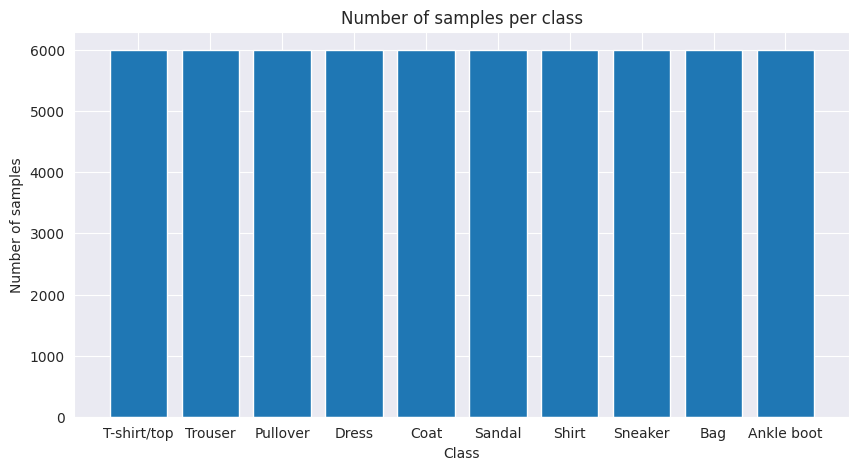

Class: T-shirt/top, Count: 6000
Class: Trouser, Count: 6000
Class: Pullover, Count: 6000
Class: Dress, Count: 6000
Class: Coat, Count: 6000
Class: Sandal, Count: 6000
Class: Shirt, Count: 6000
Class: Sneaker, Count: 6000
Class: Bag, Count: 6000
Class: Ankle boot, Count: 6000


In [5]:
# Visualize Samples per Class

# count number of samples per class
unique, counts = torch.unique(targets, return_counts=True)

plt.figure(figsize=(10,5))
plt.bar(class_names, counts.numpy(),)
plt.title("Number of samples per class")
plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.show()

for cls_idx, count in zip(unique, counts):
    print(f"Class: {class_names[cls_idx]}, Count: {count.item()}")
    

The dataset is balanced, with each class having 6000 samples.

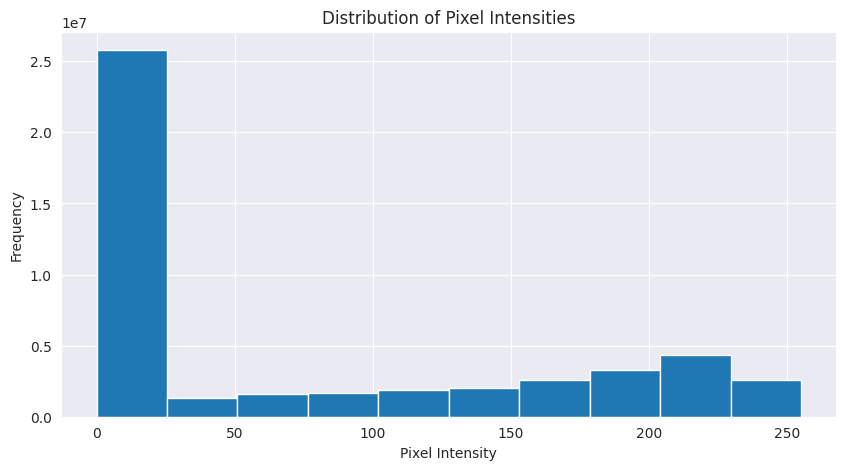

Min pixel intensity: 0.0
Max pixel intensity: 255.0
Mean pixel intensity: 72.94034576416016
Std pixel intensity: 90.02118682861328


In [6]:
# Visualize distribution of pixel intensities
plt.figure(figsize=(10,5))
plt.hist(all_params_float.flatten().numpy())
plt.title("Distribution of Pixel Intensities (Uint8)")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()

print(f"Min pixel intensity: {all_params_float.min()}")
print(f"Max pixel intensity: {all_params_float.max()}")
print(f"Mean pixel intensity: {all_params_float.mean()}")
print(f"Std pixel intensity: {all_params_float.std()}")

Majority of pixels are dark (low intensity values) - indicating background color, with a mean pixel intensity of around 70.

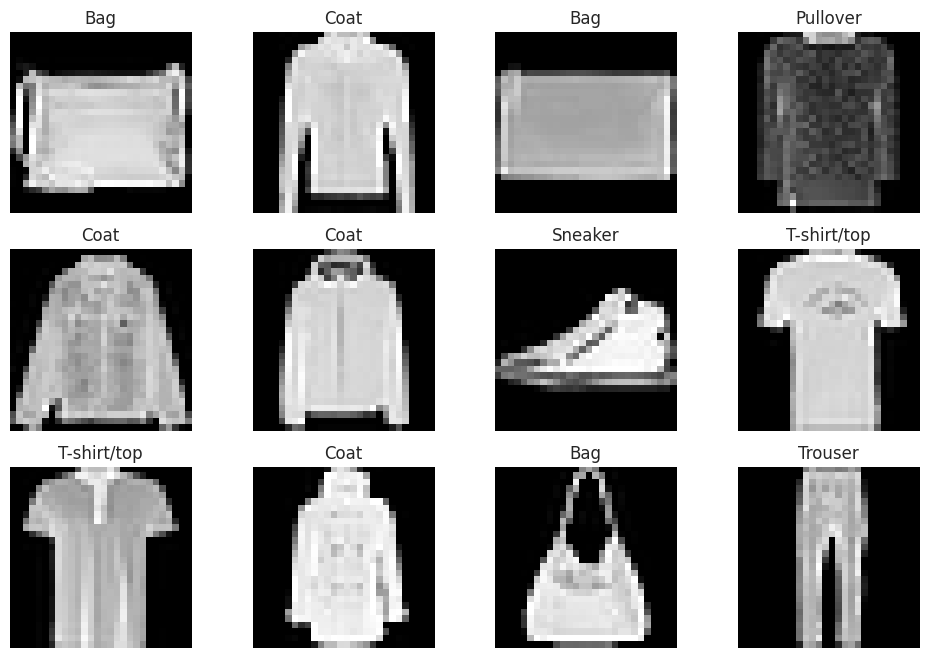

In [7]:
# Visualize some sample images
figure = plt.figure(figsize=(12, 8))
cols, rows = 4, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(data), size=(1,)).item()
    img, label = data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(class_names[label])
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

## Define Neural Network

In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size=28*28, hidden_size=[256, 64], output_size=10):
        super().__init__()
        self.flatten = nn.Flatten() # flatten the image from 28*28 to 784
        
        layers = []
        in_size = input_size
        
        for hidden_dim in hidden_size:
            layers.append(nn.Linear(in_size, hidden_dim))
            layers.append(nn.ReLU())
            in_size = hidden_dim
        
        # output layer
        layers.append(nn.Linear(in_size, output_size))
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.flatten(x)
        logits = self.model(x)
        return logits

### Training Loop

In [18]:
def train_and_eval_model(model, train_loader, test_loader, loss_fn, optimizer, device, epochs=5, verbose=False, evaluate=True):
    model.to(device)
    
    history = {'train_loss': [], 'train_acc': []}
    
    if evaluate:
        history['test_loss'] = []
        history['test_acc'] = []
    
    for epoch in range(epochs):
        model.train()
        loss_epoch = 0.0
        correct_train = 0
        total_train = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # gradient zeroing
            optimizer.zero_grad()
            
            # forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            
            # backward pass
            loss.backward()
            
            # weight update
            optimizer.step()
            
            # stats
            loss_epoch += loss.item()
            predicted = torch.max(outputs.data, 1)[1]
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            
        avg_train_loss = loss_epoch / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        
        if evaluate:
            with torch.no_grad(): # turn off gradient evaluation for validation
                model.eval()
                test_loss_epoch = 0.0
                correct_test = 0
                total_test = 0
                
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    
                    outputs = model(inputs)
                    loss = loss_fn(outputs, labels)
                    
                    test_loss_epoch += loss.item()
                    predicted = torch.max(outputs.data, 1)[1] # the classification is based on the max probability
                    total_test += labels.size(0)
                    correct_test += (predicted == labels).sum().item()
                    
                avg_test_loss = test_loss_epoch / len(test_loader)
                test_accuracy = 100 * correct_test / total_test
            
        # record history
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_accuracy)
        
        if evaluate:
            history['test_loss'].append(avg_test_loss)
            history['test_acc'].append(test_accuracy)
    
    if verbose:
        if evaluate:
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")
        else:
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%")
            
    return history

## Tests

### Test 1: 1-hidden layer vs 2-hidden layers + different hidden layer sizes

In [57]:
train_data = torchvision.datasets.FashionMNIST(root='lab5/data', train=True, download = True, transform=torchvision.transforms.ToTensor())
test_data = torchvision.datasets.FashionMNIST(root='lab5/data', train=False, download = True, transform=torchvision.transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1000, shuffle=False)

loss_fn = nn.CrossEntropyLoss()

epochs = 10

# configs
configs_1_layer = [[32], [64], [128], [256], [512]]
configs_2_layers = [[32, 16], [64, 32], [128, 64], [256, 128], [512, 256]]

all_configs = configs_1_layer + configs_2_layers
histories = {}

for config in all_configs:
    print(f"Training model with hidden layers: {config}")
    model = NeuralNetwork(hidden_size=config)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    
    history = train_and_eval_model(model, train_loader, test_loader, loss_fn, optimizer, device, epochs=epochs, verbose=True, evaluate=True)
    histories[str(config)] = history

Training model with hidden layers: [32]
Epoch [10/10], Train Loss: 0.3133, Train Acc: 88.59%, Test Loss: 0.3733, Test Acc: 86.64%
Training model with hidden layers: [64]
Epoch [10/10], Train Loss: 0.2836, Train Acc: 89.66%, Test Loss: 0.3580, Test Acc: 87.01%
Training model with hidden layers: [128]
Epoch [10/10], Train Loss: 0.2578, Train Acc: 90.37%, Test Loss: 0.3393, Test Acc: 87.40%
Training model with hidden layers: [256]
Epoch [10/10], Train Loss: 0.2350, Train Acc: 91.29%, Test Loss: 0.3448, Test Acc: 88.15%
Training model with hidden layers: [512]
Epoch [10/10], Train Loss: 0.2234, Train Acc: 91.51%, Test Loss: 0.3266, Test Acc: 88.78%
Training model with hidden layers: [32, 16]
Epoch [10/10], Train Loss: 0.3264, Train Acc: 88.26%, Test Loss: 0.3919, Test Acc: 85.86%
Training model with hidden layers: [64, 32]
Epoch [10/10], Train Loss: 0.2809, Train Acc: 89.55%, Test Loss: 0.3465, Test Acc: 87.58%
Training model with hidden layers: [128, 64]
Epoch [10/10], Train Loss: 0.2467,

### Plot results


TOP 3 MODELS BY: ACC
1. 1-L [512] : 88.97%
2. 2-L [512, 256] : 88.84%
3. 1-L [256] : 88.76%



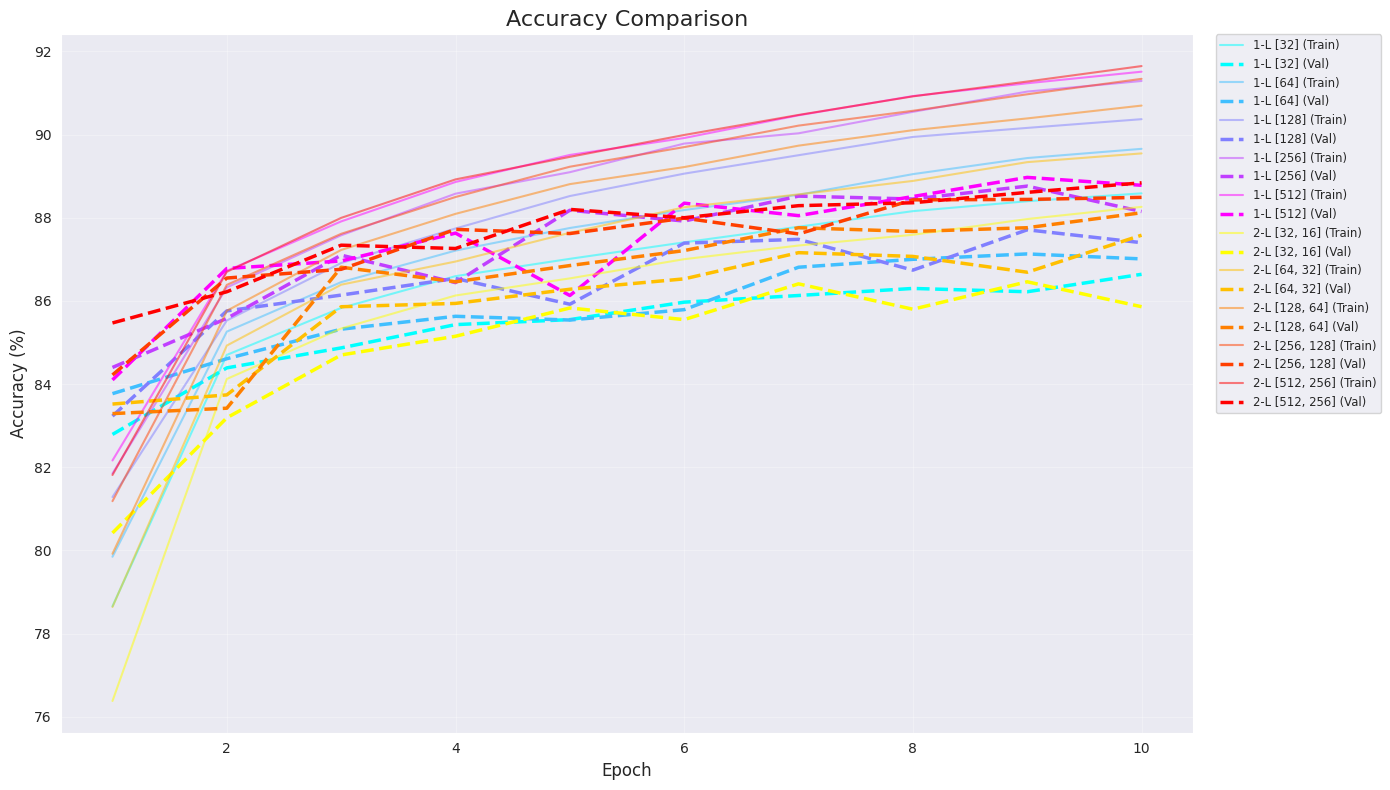


TOP 3 MODELS BY: LOSS
1. 1-L [512] : 0.3167
2. 1-L [256] : 0.3237
3. 2-L [256, 128] : 0.3239



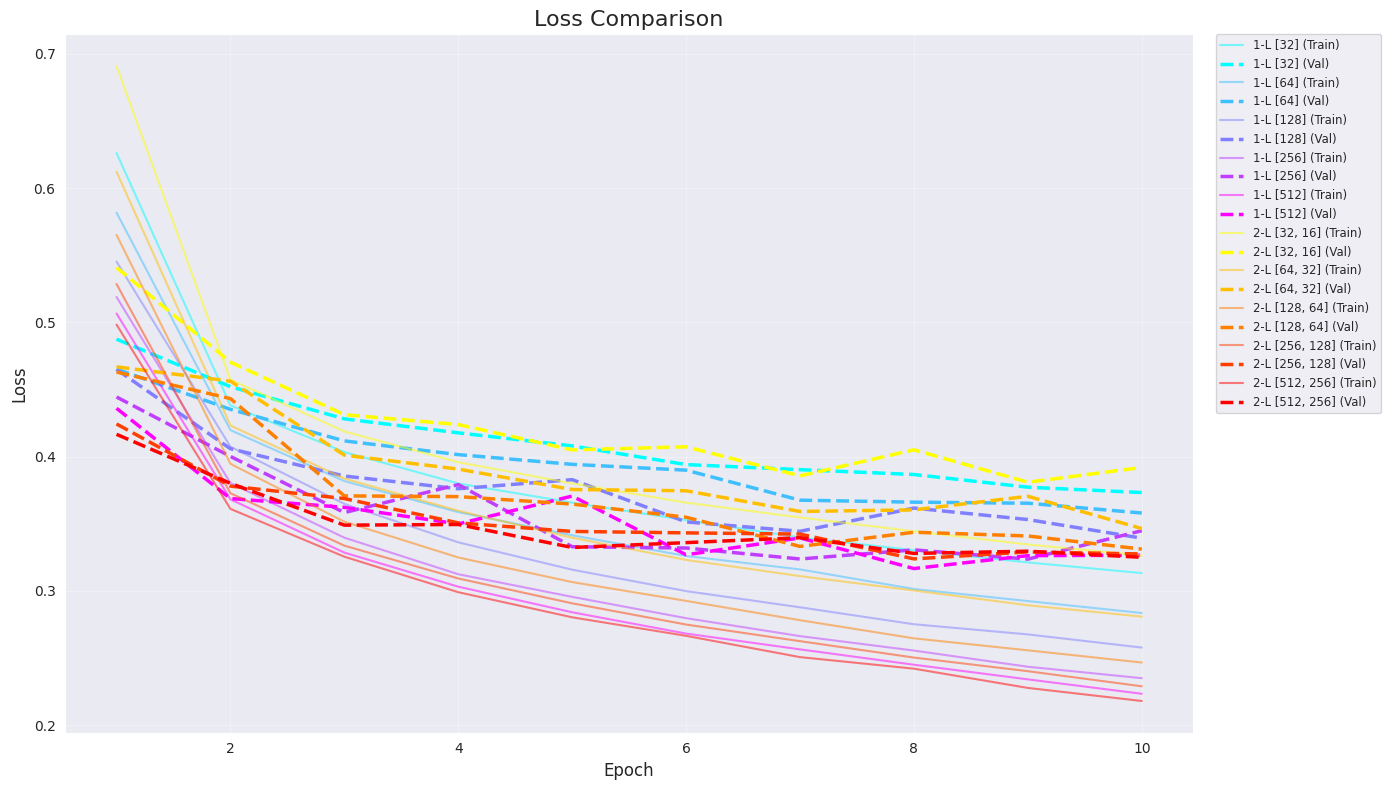

In [58]:
def plot_train_val_comparison(results, metric_type, title, ylabel):
    """
    Plots the Train vs Val comparison and prints the Top 3 best models.
    """
    plt.figure(figsize=(14, 8))
    
    # High contrast colors
    colors_1 = plt.cm.cool(np.linspace(0, 1, 5))      # 1-layer (Cool colors)
    colors_2 = plt.cm.autumn_r(np.linspace(0, 1, 5))  # 2-layer (Warm colors)
    
    # List to store results (name, score)
    model_scores = []
    
    i = 0
    for name, history in results.items():
        # Color selection
        if "," in name:
            color = colors_2[i % 5]
            label_prefix = "2-L"
        else:
            color = colors_1[i % 5]
            label_prefix = "1-L"
            
        val_key = 'test_' + metric_type
        train_key = 'train_' + metric_type
        
        train_values = history[train_key]
        val_values = history[val_key]
        epochs = range(1, len(train_values) + 1)
        
        # PLOTTING
        plt.plot(epochs, train_values, 
                 color=color, linestyle='-', linewidth=1.5, alpha=0.5,
                 label=f"{label_prefix} {name} (Train)")
        
        plt.plot(epochs, val_values, 
                 color=color, linestyle='--', linewidth=2.5, alpha=1.0,
                 label=f"{label_prefix} {name} (Val)")
        
        # --- GATHERING RESULTS FOR RANKING ---
        # Get the best score achieved by the model in any epoch
        if metric_type == 'acc':
            best_score = max(val_values) # Highest accuracy
        else:
            best_score = min(val_values) # Lowest loss
            
        model_scores.append((f"{label_prefix} {name}", best_score))
        
        if label_prefix == "1-L" and i == 4: 
            i = -1 
        i += 1

    # --- SORTING AND PRINTING TOP 3 LOGIC ---
    print(f"\n{'='*40}")
    print(f"TOP 3 MODELS BY: {metric_type.upper()}")
    print(f"{'='*40}")
    
    # Sorting:
    # If 'acc' -> reverse=True (descending order)
    # If 'loss' -> reverse=False (ascending order)
    reverse_sort = True if metric_type == 'acc' else False
    
    # Sort the list of tuples by the second element (score)
    model_scores.sort(key=lambda x: x[1], reverse=reverse_sort)
    
    for rank, (model_name, score) in enumerate(model_scores[:3], 1):
        if metric_type == 'acc':
            print(f"{rank}. {model_name} : {score:.2f}%")
        else:
            print(f"{rank}. {model_name} : {score:.4f}")
            
    print(f"{'='*40}\n")

    # End plotting
    plt.title(title, fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize='small')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# EXAMPLE CALL (assuming you have a 'histories' dictionary with results):
plot_train_val_comparison(histories, 'acc', 'Accuracy Comparison', 'Accuracy (%)')
plot_train_val_comparison(histories, 'loss', 'Loss Comparison', 'Loss')

From the results, we can observe that:
- There is no clear rule to if 1-layer or 2-layer models perform better on this dataset. The difference in performance amongst the best 3 architectures is under 0.2%.
- Validation accuracy and loss curves tend to show worse performance compared to training curves, indicating some level of overfitting.
- The best performing 1-layer model is [512], and the best performing 2-layer model is [512, 256] (val accuracy).

In [59]:
# 1. Narrowing Networks
configs_narrowing = [
    [128, 64], 
    [256, 128], 
    [512, 256]
]

# 2. Widening Networks
configs_widening = [
    [64, 128], 
    [128, 256], 
    [256, 512]
]

all_configs = configs_narrowing + configs_widening
histories = {}


for config in all_configs:
    print(f"Training config: {config}")
    
    model = NeuralNetwork(hidden_size=config).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    history = train_and_eval_model(model, train_loader, test_loader, loss_fn, optimizer, device, epochs=epochs, verbose=False, evaluate=True)
    
    histories[str(config)] = history

Training config: [128, 64]
Training config: [256, 128]
Training config: [512, 256]
Training config: [64, 128]
Training config: [128, 256]
Training config: [256, 512]



--- TOP RESULTS (ACC) ---
1. Narrow (Funnel) [512, 256]: 89.19%
2. Wide (Inverted) [256, 512]: 88.91%
3. Narrow (Funnel) [256, 128]: 88.67%
4. Wide (Inverted) [128, 256]: 88.50%
5. Narrow (Funnel) [128, 64]: 88.44%
6. Wide (Inverted) [64, 128]: 88.09%


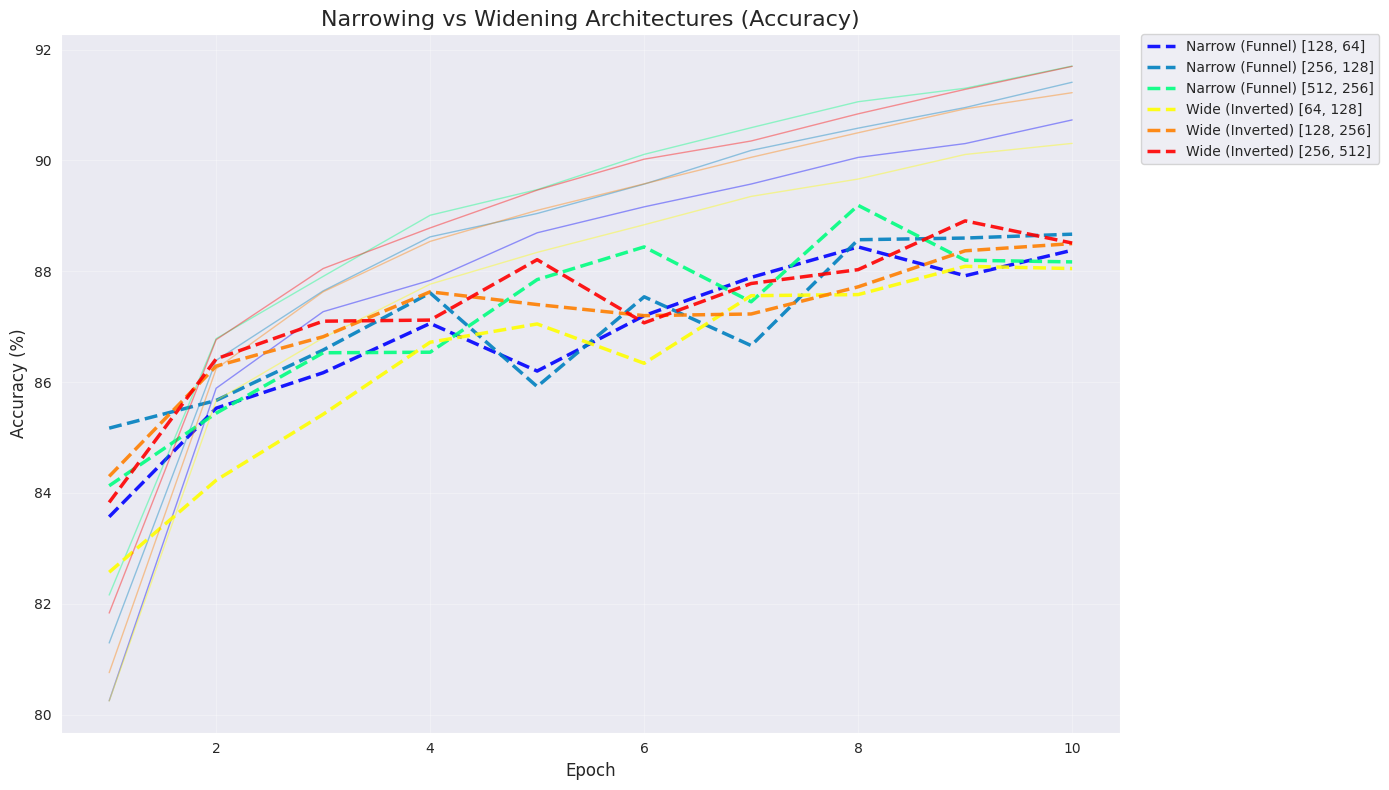


--- TOP RESULTS (LOSS) ---
1. Narrow (Funnel) [512, 256]: 0.3162
2. Narrow (Funnel) [256, 128]: 0.3199
3. Wide (Inverted) [256, 512]: 0.3247
4. Narrow (Funnel) [128, 64]: 0.3306
5. Wide (Inverted) [64, 128]: 0.3360
6. Wide (Inverted) [128, 256]: 0.3376


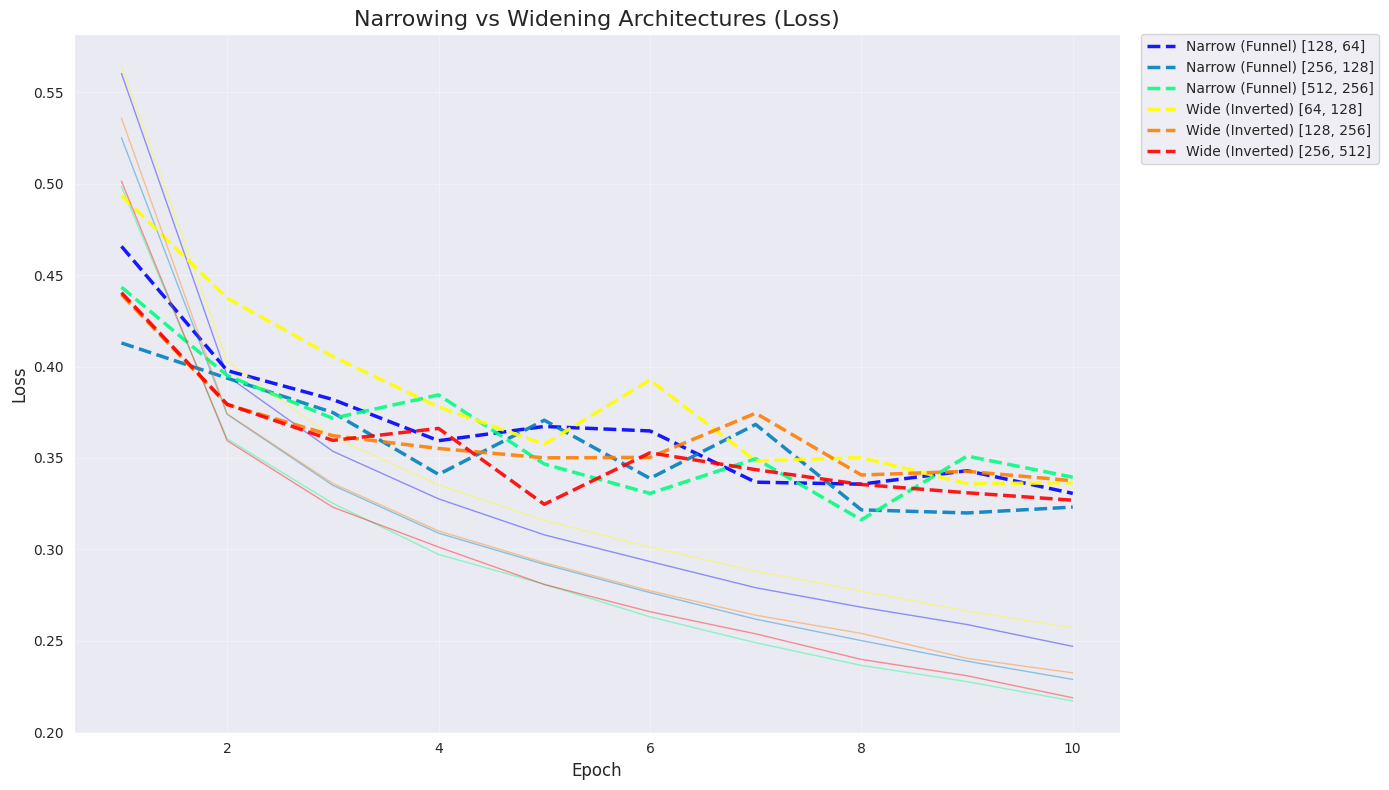

In [60]:
import ast
import matplotlib.pyplot as plt
import numpy as np

def plot_architecture_comparison(results, metric_type, title, ylabel):
    plt.figure(figsize=(14, 8))
    
    # Color palettes
    colors_narrow = plt.cm.winter(np.linspace(0, 1, len(configs_narrowing))) # Cool colors
    colors_wide = plt.cm.autumn_r(np.linspace(0, 1, len(configs_widening)))  # Warm colors
    
    # Color counters
    idx_n, idx_w = 0, 0
    
    model_scores = []

    for name, history in results.items():
        # Parse string "[128, 64]" back to list [128, 64]
        config = ast.literal_eval(name)
        
        # Style selection logic
        if config[0] > config[1]: # Narrowing e.g., [256, 128]
            color = colors_narrow[idx_n % len(colors_narrow)]
            label_prefix = "Narrow (Funnel)"
            idx_n += 1
        else: # Widening e.g., [128, 256]
            color = colors_wide[idx_w % len(colors_wide)]
            label_prefix = "Wide (Inverted)"
            idx_w += 1

        val_key = 'test_' + metric_type
        train_key = 'train_' + metric_type
        
        train_values = history[train_key]
        val_values = history[val_key]
        epochs = range(1, len(train_values) + 1)
        
        # Plotting (Train - thin line, Val - thick line)
        plt.plot(epochs, train_values, color=color, linestyle='-', linewidth=1, alpha=0.4)
        plt.plot(epochs, val_values, color=color, linestyle='--', linewidth=2.5, alpha=0.9,
                 label=f"{label_prefix} {name}")
        
        # Collecting results for ranking
        best_score = max(val_values) if metric_type == 'acc' else min(val_values)
        model_scores.append((f"{label_prefix} {name}", best_score))

    # --- Ranking ---
    print(f"\n--- TOP RESULTS ({metric_type.upper()}) ---")
    reverse_sort = True if metric_type == 'acc' else False
    model_scores.sort(key=lambda x: x[1], reverse=reverse_sort)
    
    for rank, (m_name, score) in enumerate(model_scores, 1):
        val_str = f"{score:.2f}%" if metric_type == 'acc' else f"{score:.4f}"
        print(f"{rank}. {m_name}: {val_str}")

    plt.title(title, fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Usage
plot_architecture_comparison(histories, 'acc', 'Narrowing vs Widening Architectures (Accuracy)', 'Accuracy (%)')
plot_architecture_comparison(histories, 'loss', 'Narrowing vs Widening Architectures (Loss)', 'Loss')

In this experiment comparing narrowing and widening architectures, we observe that:
- In this dataset, there is no clear advantage of narrowing architectures over widening ones, or vice versa. Both types can achieve comparable performance depending on the specific layer sizes chosen.
- The best performing model was a narrowing architecture with layers [512, 256], achieving high accuracy and low loss.
- Some widening architectures also performed well, indicating that the choice of architecture should be tailored to the specific problem and dataset.
- In the following experiments, we will continue to use narrowing architectures as they are more commonly used and tend to generalize better in many scenarios.

Training: [512, 512]...
Training: [512, 256]...
Training: [512, 128]...
Training: [512, 64]...
Training: [256, 256]...
Training: [256, 128]...
Training: [256, 64]...
Training: [256, 32]...


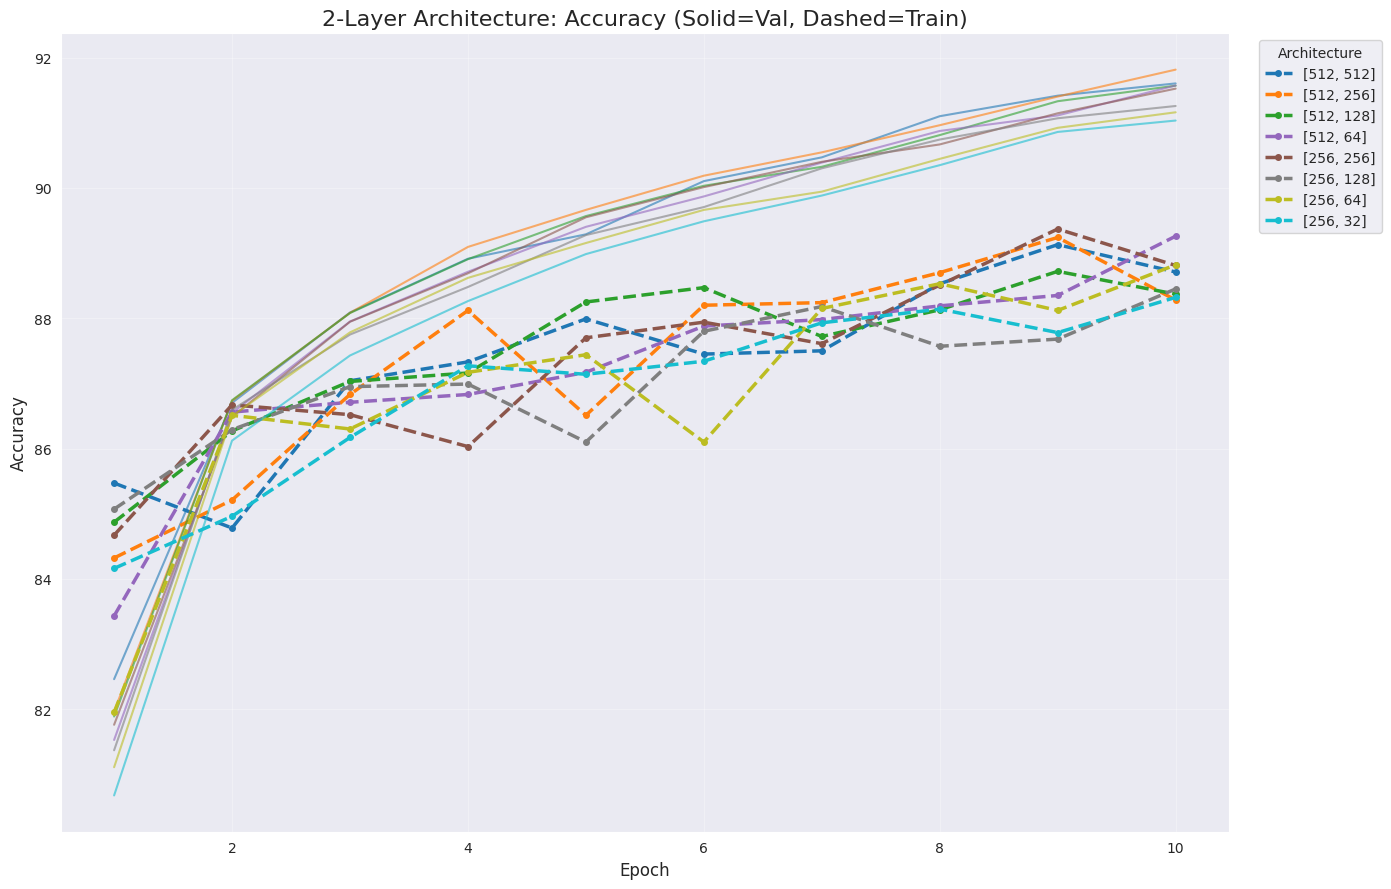


🏆 FINAL RANKING (Metric: ACC)
🥇 [256, 256]      : 89.37%
2. [512, 64]       : 89.26%
3. [512, 256]      : 89.24%
   [512, 512]      : 89.13%
   [256, 64]       : 88.82%
   [512, 128]      : 88.72%
   [256, 128]      : 88.45%
   [256, 32]       : 88.32%



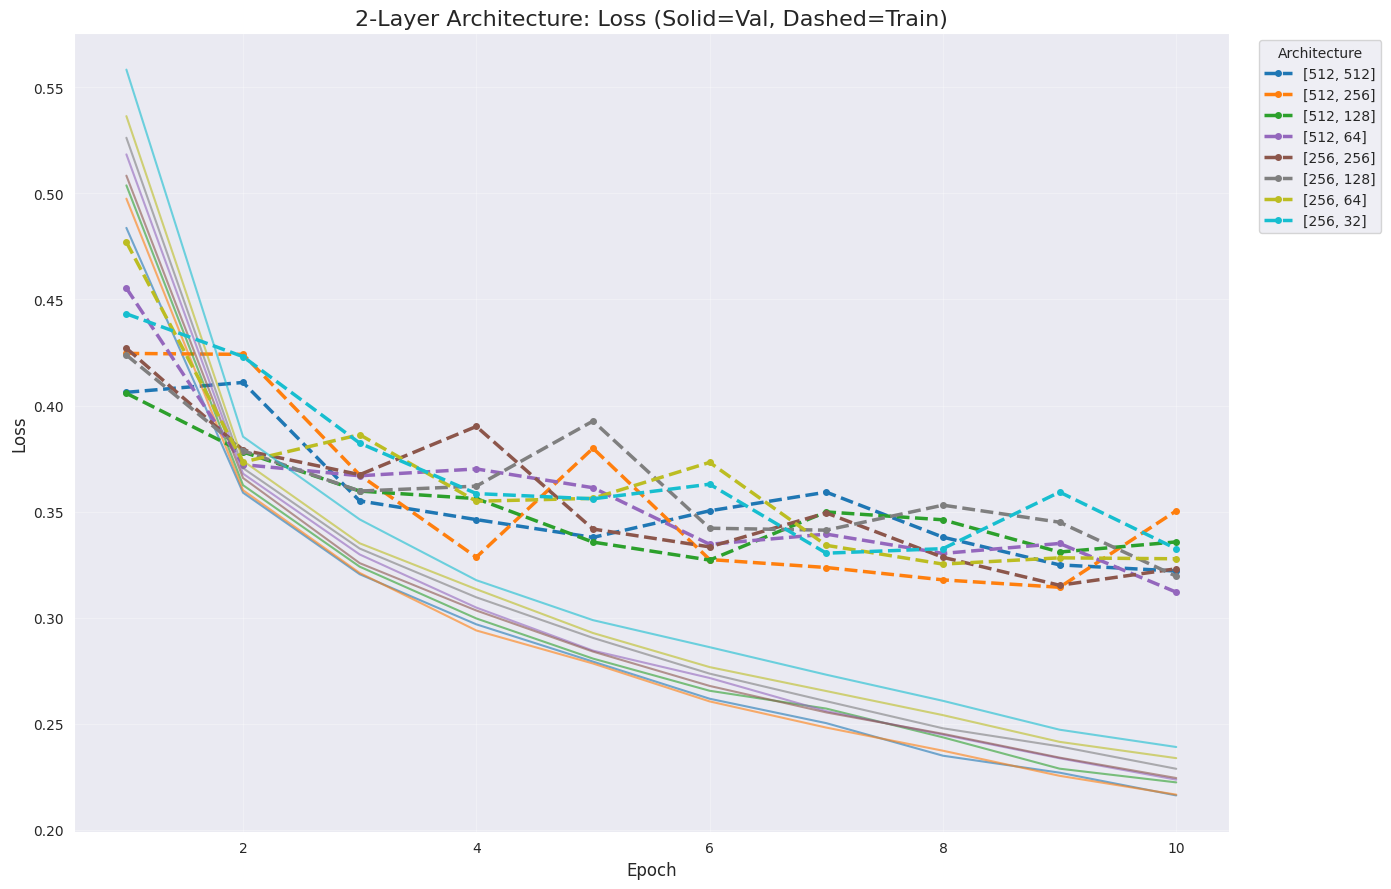


🏆 FINAL RANKING (Metric: LOSS)
🥇 [512, 64]       : 0.3120
2. [512, 256]      : 0.3143
3. [256, 256]      : 0.3153
   [256, 128]      : 0.3195
   [512, 512]      : 0.3220
   [256, 64]       : 0.3253
   [512, 128]      : 0.3271
   [256, 32]       : 0.3304



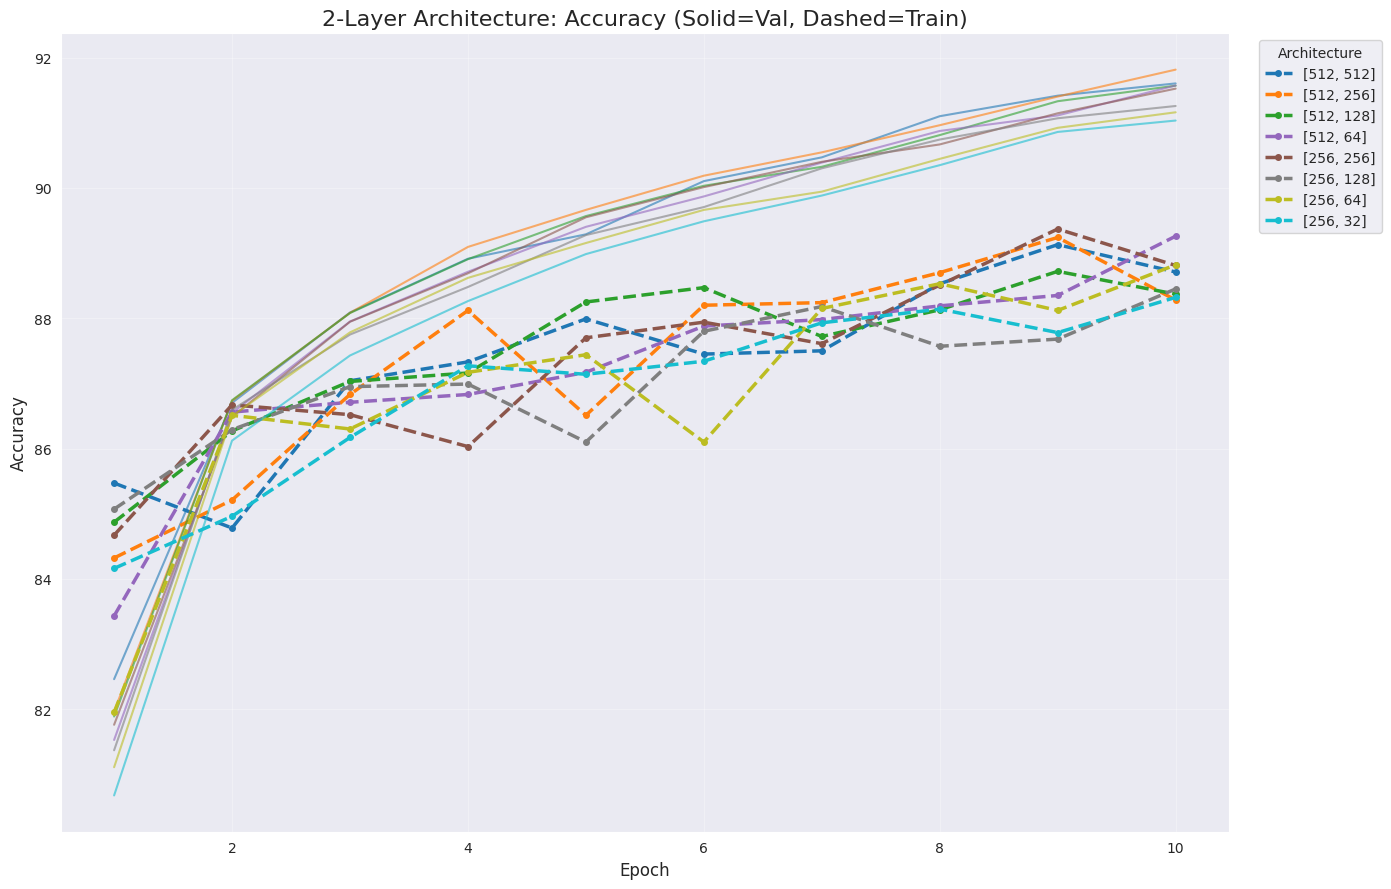


🏆 FINAL RANKING (Metric: ACC)
🥇 [256, 256]      : 89.37%
2. [512, 64]       : 89.26%
3. [512, 256]      : 89.24%
   [512, 512]      : 89.13%
   [256, 64]       : 88.82%
   [512, 128]      : 88.72%
   [256, 128]      : 88.45%
   [256, 32]       : 88.32%



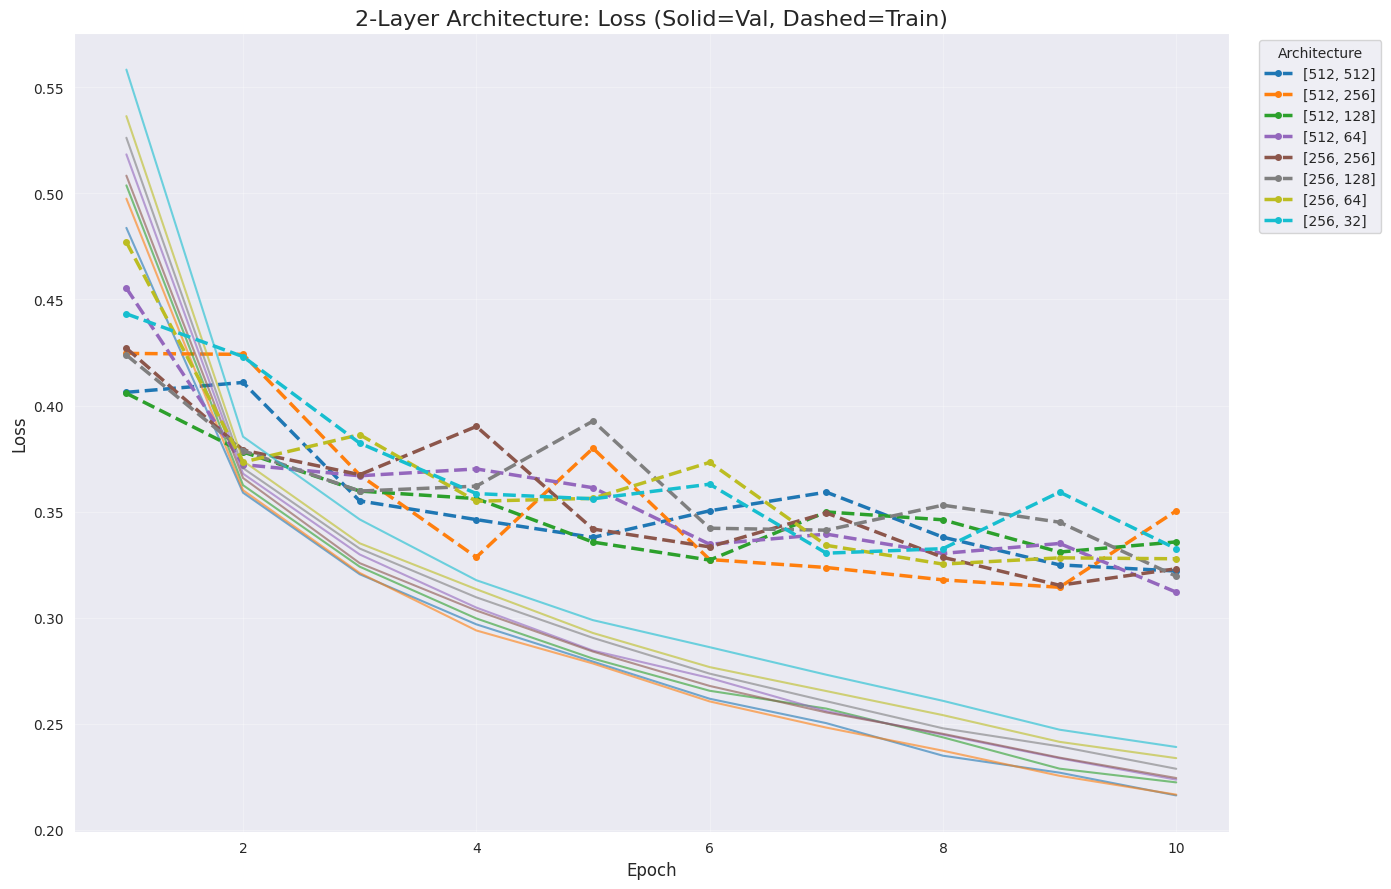


🏆 FINAL RANKING (Metric: LOSS)
🥇 [512, 64]       : 0.3120
2. [512, 256]      : 0.3143
3. [256, 256]      : 0.3153
   [256, 128]      : 0.3195
   [512, 512]      : 0.3220
   [256, 64]       : 0.3253
   [512, 128]      : 0.3271
   [256, 32]       : 0.3304



In [61]:
train_data = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
test_data = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1000, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_fn = nn.CrossEntropyLoss()

# --- 2. CONFIGURATIONS TO TEST ---
# We focus on large first layers (512/256)
configs = [
    # Group 512 (High capacity)
    [512, 512], 
    [512, 256], 
    [512, 128],
    [512, 64],
    
    # Group 256 (Medium capacity)
    [256, 256],
    [256, 128], 
    [256, 64],
    [256, 32] 
]

histories = {}
epochs = 10 


for config in configs:
    config_name = str(config)
    print(f"Training: {config_name}...")
    
    # Initialization and training
    model = NeuralNetwork(hidden_size=config).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    history = train_and_eval_model(model, train_loader, test_loader, loss_fn, optimizer, device, epochs=epochs, verbose=False, evaluate=True)
    histories[config_name] = history


def plot_best_architectures(results, metric_type='acc'):
    plt.figure(figsize=(14, 9))
    
    # Use 'tab10' palette for distinct colors per architecture
    colors = plt.cm.tab10(np.linspace(0, 1, len(results)))
    
    model_scores = []
    
    for i, (name, history) in enumerate(results.items()):
        val_key = 'test_' + metric_type
        train_key = 'train_' + metric_type
        
        # Retrieve data
        val_values = history[val_key]
        train_values = history[train_key] 
        
        epochs_range = range(1, len(val_values) + 1)
        
        # 1. Plot Training History (solid line, slightly transparent)
        plt.plot(epochs_range, train_values, 
                 color=colors[i], linestyle='-', linewidth=1.5, alpha=0.6)
        
        # 2. Plot Validation History (dashed line, Thicker, with Label)
        plt.plot(epochs_range, val_values, 
                 color=colors[i], linestyle='--', linewidth=2.5, marker='o', markersize=4, 
                 label=name)
        
        # Collect best result for ranking
        best_score = max(val_values) if metric_type == 'acc' else min(val_values)
        model_scores.append((name, best_score))

    # Titles and labels
    title_metric = "Accuracy" if metric_type == 'acc' else "Loss"
    plt.title(f'2-Layer Architecture: {title_metric} (Solid=Val, Dashed=Train)', fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel(title_metric, fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Legend only shows the Architecture names (linked to colors)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title="Architecture")
    plt.tight_layout()
    plt.show()

    # --- Print Ranking ---
    print(f"\n{'='*45}")
    print(f"🏆 FINAL RANKING (Metric: {metric_type.upper()})")
    print(f"{'='*45}")
    
    # Sort results
    reverse = True if metric_type == 'acc' else False
    model_scores.sort(key=lambda x: x[1], reverse=reverse)
    
    for rank, (name, score) in enumerate(model_scores, 1):
        score_fmt = f"{score:.2f}%" if metric_type == 'acc' else f"{score:.4f}"
        
        prefix = "🥇" if rank == 1 else (f"{rank}." if rank <= 3 else "  ")
        print(f"{prefix} {name:<15} : {score_fmt}")
    print(f"{'='*45}\n")

# --- Run Visualization ---
# Ensure 'histories' variable is populated from your training loop
if 'histories' in locals() and histories:
    plot_best_architectures(histories, 'acc')
    plot_best_architectures(histories, 'loss')
else:
    print("Please run the training loop first to populate 'histories'.")


- There is no clear advantage of larger architectures in this test. 
- The best performing architectures in this test were [512, 64] and [256, 256] achieving the highest accuracy and lowest loss on the validation set. The [512, 64] architecture also displayed stable training and validation curves, indicating good generalization.
- To get better insights, we would have to run longer training (more epochs) and possibly multiple runs to average out randomness.



=== BATCH SIZE: 16 ===
  -> Training architecture: [512, 64]
  -> Training architecture: [256, 256]
  -> Training architecture: [512]
  -> Training architecture: [256]

=== BATCH SIZE: 32 ===
  -> Training architecture: [512, 64]
  -> Training architecture: [256, 256]
  -> Training architecture: [512]
  -> Training architecture: [256]

=== BATCH SIZE: 64 ===
  -> Training architecture: [512, 64]
  -> Training architecture: [256, 256]
  -> Training architecture: [512]
  -> Training architecture: [256]

=== BATCH SIZE: 128 ===
  -> Training architecture: [512, 64]
  -> Training architecture: [256, 256]
  -> Training architecture: [512]
  -> Training architecture: [256]

=== BATCH SIZE: 256 ===
  -> Training architecture: [512, 64]
  -> Training architecture: [256, 256]
  -> Training architecture: [512]
  -> Training architecture: [256]

=== BATCH SIZE: 512 ===
  -> Training architecture: [512, 64]
  -> Training architecture: [256, 256]
  -> Training architecture: [512]
  -> Training arc

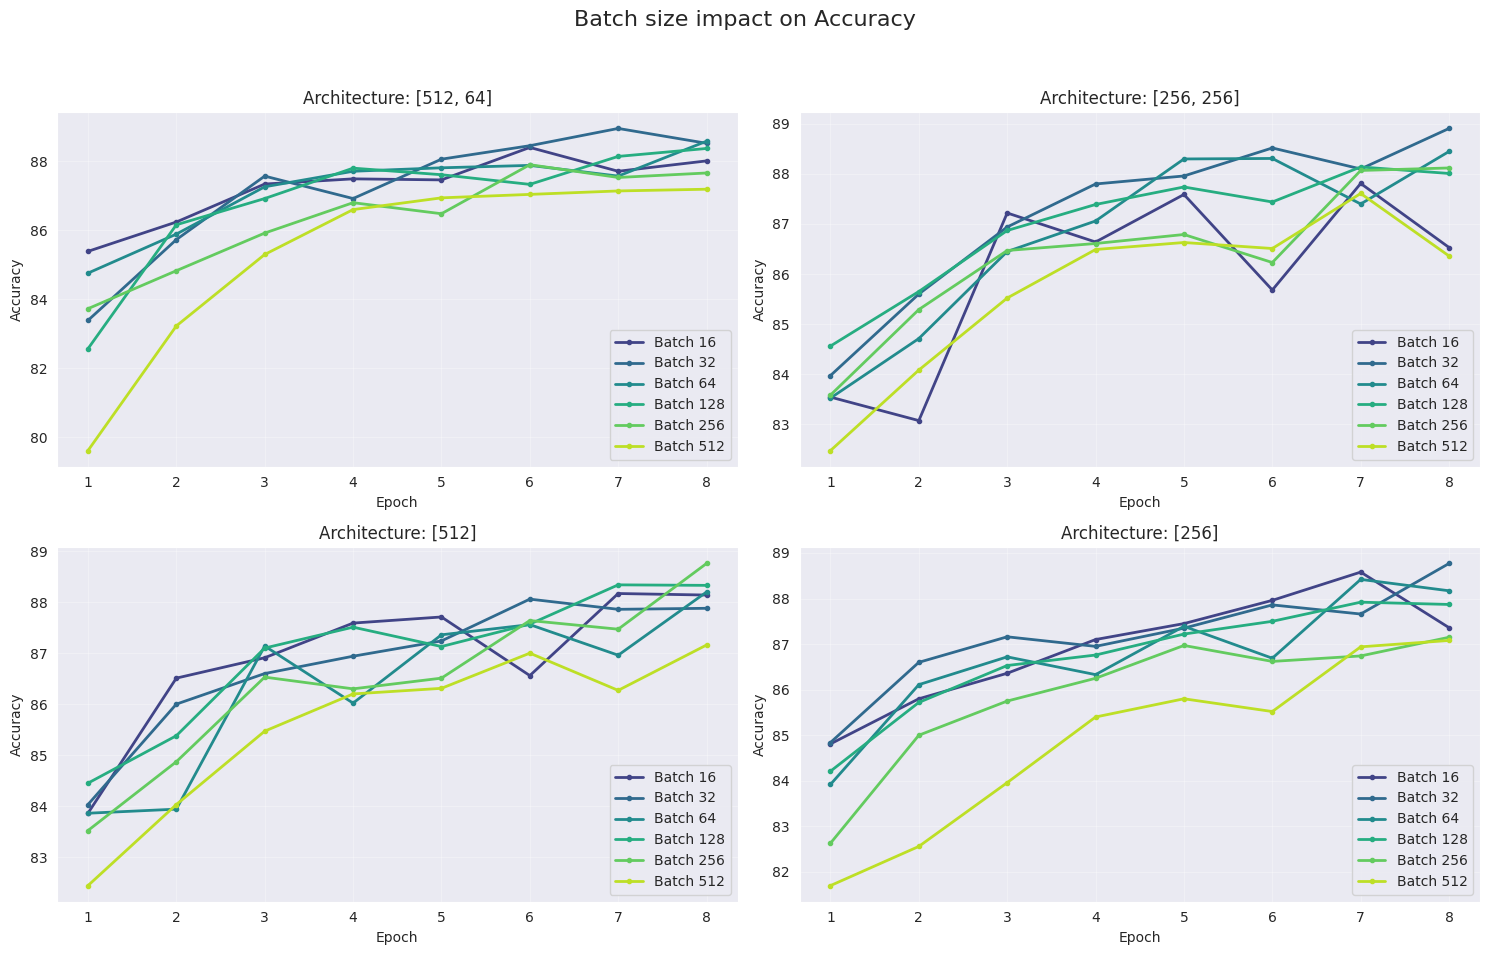

In [62]:
# --- CONFIG ---
architectures = [
    [512, 64],
    [256, 256],
    [512],
    [256]
]

batch_sizes_to_test = [16, 32, 64, 128, 256, 512]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


train_data = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
test_data = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())

# Dict to store results
# results[str(arch)][str(batch_size)] = history
results_container = {str(arch): {} for arch in architectures}

epochs = 8  


for batch_size in batch_sizes_to_test:
    print(f"\n=== BATCH SIZE: {batch_size} ===")
    
    # Test loader can have fixed batch size,since we are not training on it
    curr_train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    curr_test_loader = torch.utils.data.DataLoader(test_data, batch_size=1000, shuffle=False)
    
    for arch in architectures:
        print(f"  -> Training architecture: {arch}")
        
        # initialization
        model = NeuralNetwork(hidden_size=arch).to(device)
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        
        # Training
        history = train_and_eval_model(model, curr_train_loader, curr_test_loader, 
                                       loss_fn, optimizer, device, epochs=epochs, verbose=False)
        
        # score saving
        results_container[str(arch)][batch_size] = history




def plot_batch_size_impact(results, metric='test_acc'):
    # 2x2 grid
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    axs = axs.flatten() # flatten for easy indexing
    
    # colors for different batch sizes
    colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(batch_sizes_to_test)))
    
    metric_name = "Accuracy" if 'acc' in metric else "Loss"
    
    for i, arch in enumerate(architectures):
        ax = axs[i]
        arch_str = str(arch)
        data_for_arch = results[arch_str]
        
        for j, bs in enumerate(batch_sizes_to_test):
            history = data_for_arch[bs]
            values = history[metric]
            epochs_range = range(1, len(values) + 1)
            
            ax.plot(epochs_range, values, marker='.', label=f"Batch {bs}", 
                    color=colors[j], linewidth=2)
            
            # final value annotation
            final_val = values[-1]
            # ax.text(epochs_range[-1], final_val, f"{final_val:.1f}%", fontsize=8, va='bottom')

        ax.set_title(f"Architecture: {arch_str}")
        ax.set_xlabel("Epoch")
        ax.set_ylabel(metric_name)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='lower right')

    plt.suptitle(f"Batch size impact on {metric_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Zostaw miejsce na tytuł
    plt.show()

# show results
plot_batch_size_impact(results_container, metric='test_acc')

From the batch size experiments, we can observe that:
- The batch size should be tuned based on the architecture and dataset. There is no one-size-fits-all answer.
- For 2-layer architectures, the 32 and 64 batch sizes provided the best validation accuracy.
- There was a significant difference between how different architectures responded to extreme batch sizes (very small or very large). Batch sizes in the middle (32-128) tended to perform better across all architectures.

In [65]:
from torch.utils.data import DataLoader, Subset

# --- config ---
architectures = [
    [512, 64],
    [256, 256],
    [512],
    [256]
]

# percentages of data to use
data_ratios = [0.01, 0.1, 1.0] # 1%, 10%, 100%

# settings
batch_size = 64 
epochs = 10   
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ładowanie pełnych danych
full_train_data = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
full_test_data = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())

# test loader is always full - we evaluate on full test set
test_loader = DataLoader(full_test_data, batch_size=1000, shuffle=False)

# results dict: results[str(arch)][ratio]
results_container = {str(arch): {} for arch in architectures}



# --- MAIN LOOP ---
for ratio in data_ratios:
    print(f"\n=== TRAINING ON {int(ratio*100)}% DATA ===")
    
    # 1. subset creation
    train_size = len(full_train_data)
    indices_count = int(train_size * ratio)
    
    # random subset indices
    # set seed for reproducibility
    torch.manual_seed(42) 
    indices = torch.randperm(train_size)[:indices_count]
    
    train_subset = Subset(full_train_data, indices)
    
    # subset loader
    subset_train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    
    print(f"   Train images count: {len(train_subset)}")

    for arch in architectures:
        # initialize model
        model = NeuralNetwork(hidden_size=arch).to(device)
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        
        # training
        # small train set, big test set
        history = train_and_eval_model(model, subset_train_loader, test_loader, 
                                       loss_fn, optimizer, device, epochs=epochs, verbose=False)
        
        results_container[str(arch)][ratio] = history
        print(f"   -> Arch {arch}: Acc {history['test_acc'][-1]:.2f}%")


=== TRAINING ON 1% DATA ===
   Train images count: 600
   -> Arch [512, 64]: Acc 76.46%
   -> Arch [256, 256]: Acc 73.92%
   -> Arch [512]: Acc 76.76%
   -> Arch [256]: Acc 76.99%

=== TRAINING ON 10% DATA ===
   Train images count: 6000
   -> Arch [512, 64]: Acc 83.51%
   -> Arch [256, 256]: Acc 83.79%
   -> Arch [512]: Acc 82.89%
   -> Arch [256]: Acc 83.65%

=== TRAINING ON 100% DATA ===
   Train images count: 60000
   -> Arch [512, 64]: Acc 87.95%
   -> Arch [256, 256]: Acc 88.14%
   -> Arch [512]: Acc 89.13%
   -> Arch [256]: Acc 87.83%


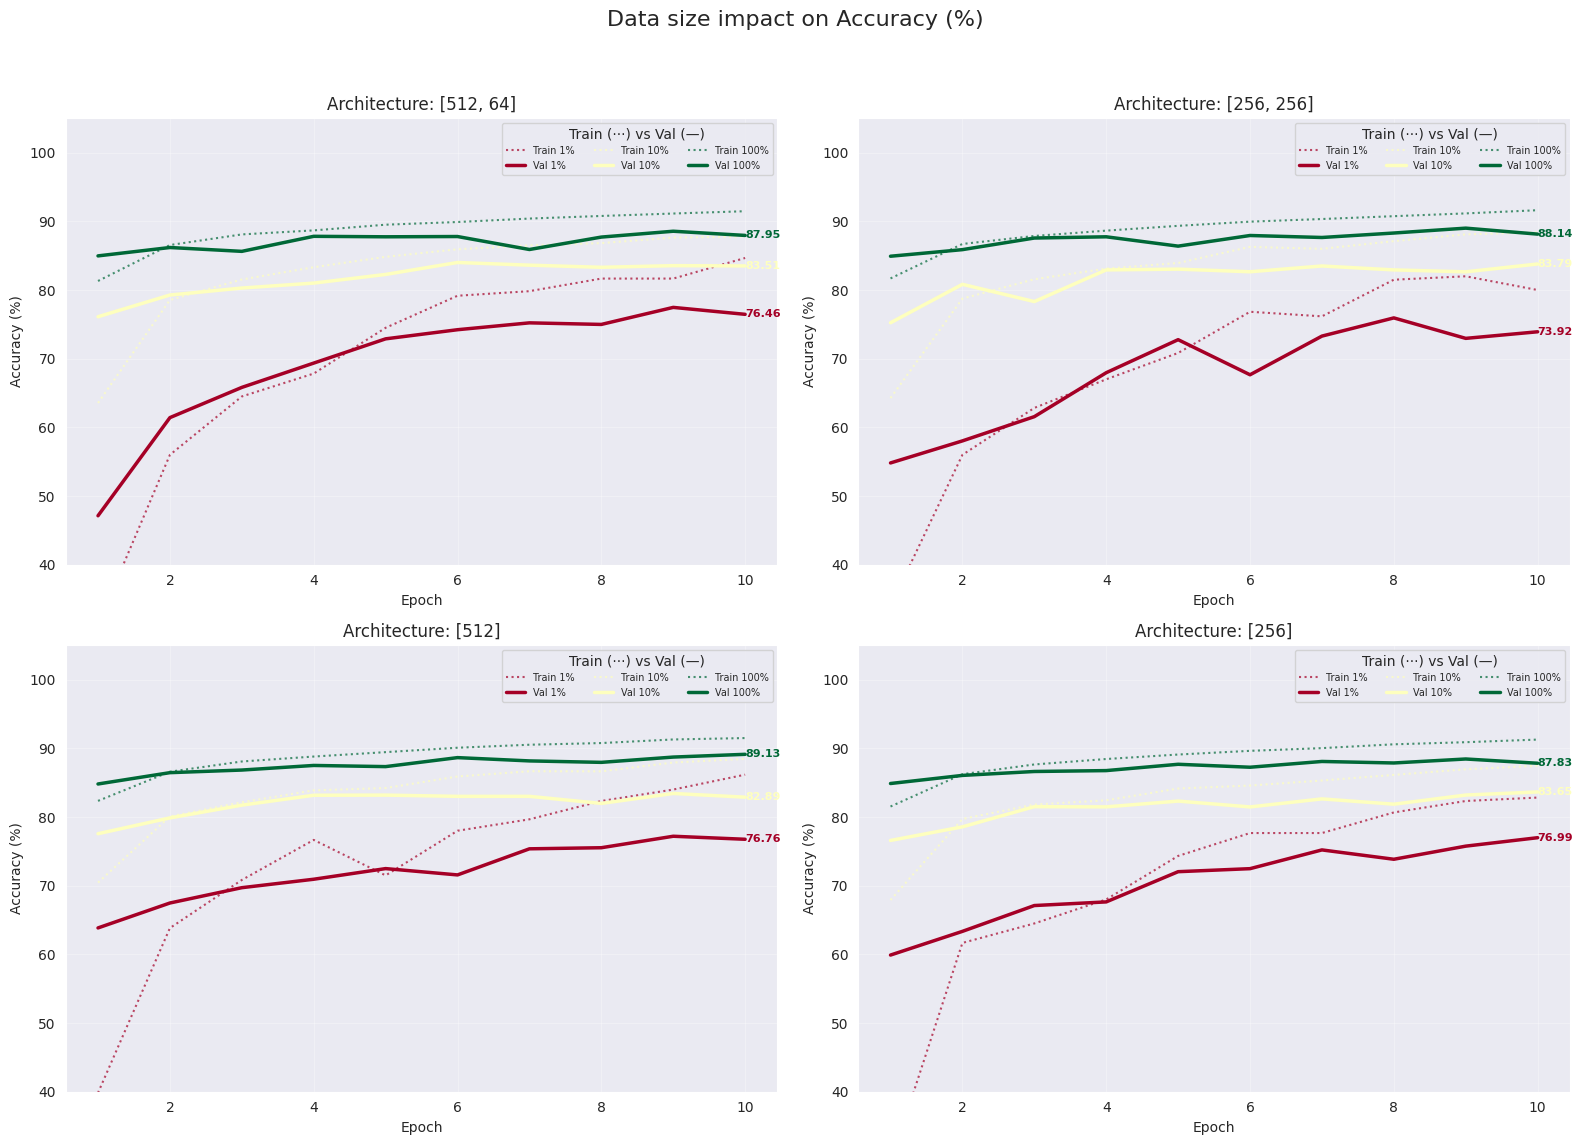

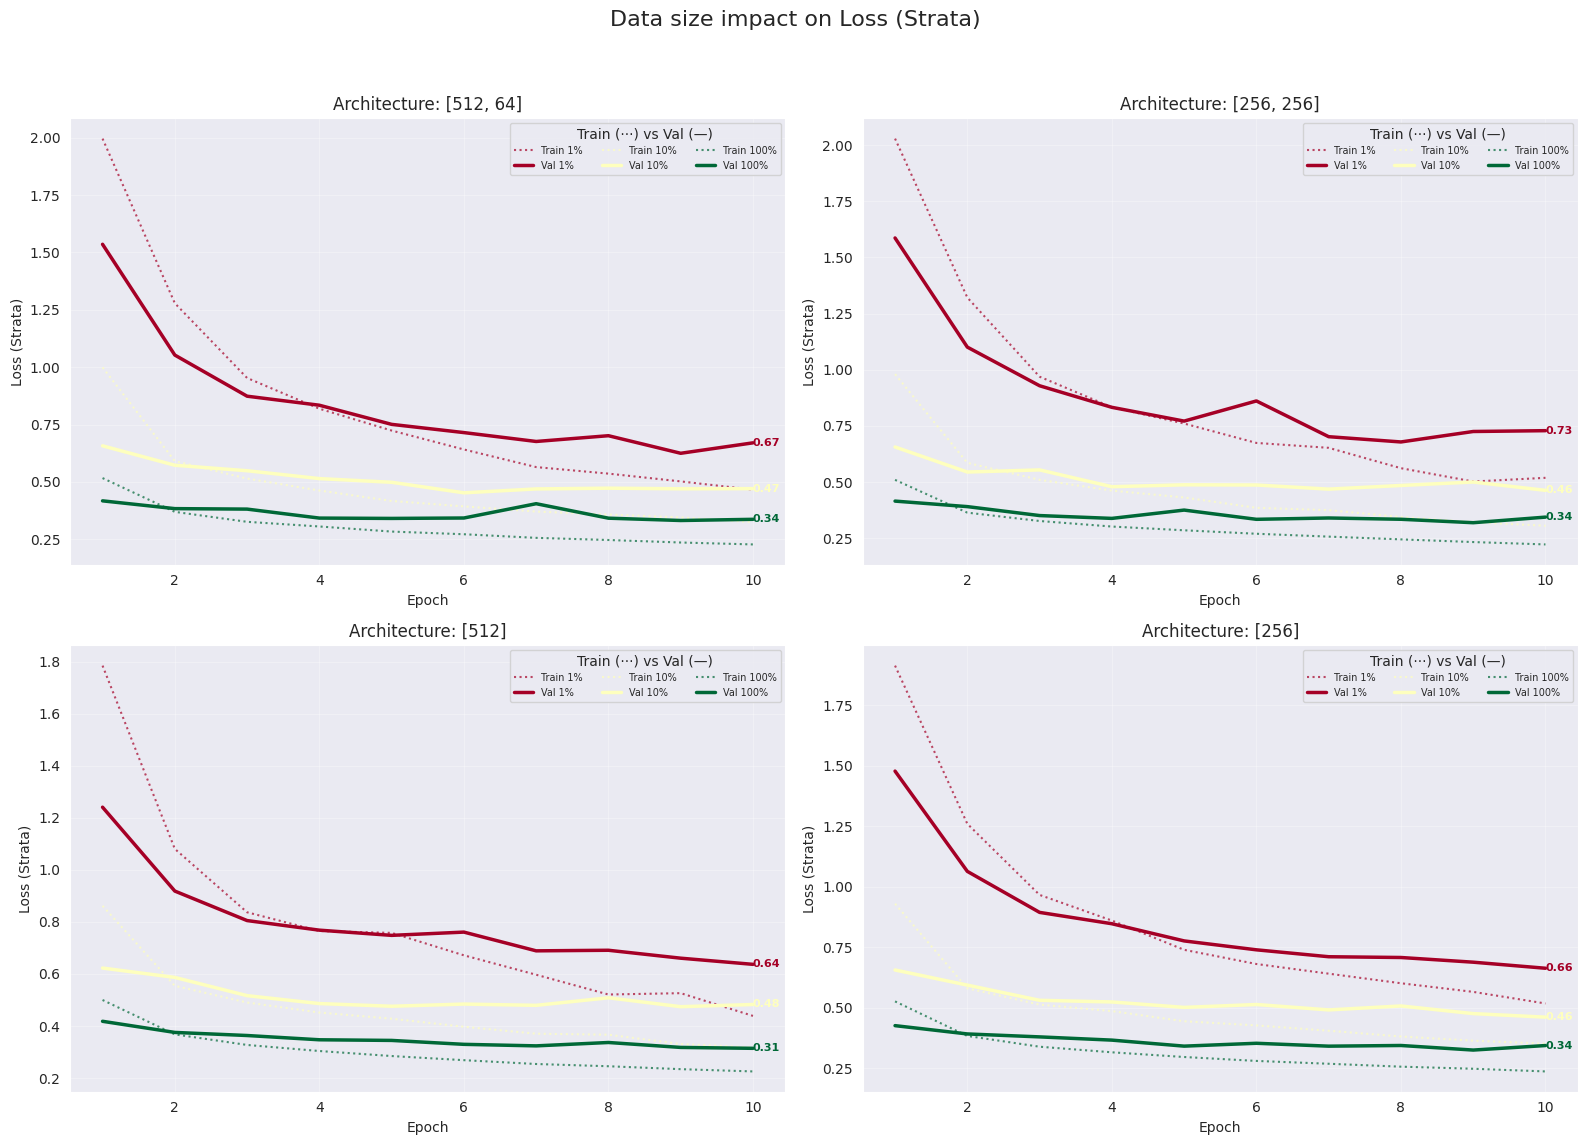

In [66]:
import matplotlib.pyplot as plt
import numpy as np

def plot_data_size_impact_full(results):
    """
    Two sets of plost: 1 for Acc, 1 for Loss.
    Train (dotted line) vs Val (solid line).
    """
    
    # metrics to draw
    metrics_config = [
        {'key': 'acc', 'title': 'Accuracy (%)', 'ylim': (40, 105)},
        {'key': 'loss', 'title': 'Loss (Strata)', 'ylim': None} # Loss nie ma sztywnego limitu
    ]
    
    # Colors: Red (1%) -> Yellow (10%) -> Green (100%)
    colors = plt.cm.RdYlGn(np.linspace(0, 1, len(data_ratios)))

    # loop for each metric, first Acc, then Loss
    for metric_cfg in metrics_config:
        metric = metric_cfg['key']
        
        fig, axs = plt.subplots(2, 2, figsize=(16, 12))
        axs = axs.flatten()
        
        for i, arch in enumerate(architectures):
            ax = axs[i]
            arch_str = str(arch)
            data_for_arch = results[arch_str]
            
            # loop for each data ratio
            for j, ratio in enumerate(data_ratios):
                history = data_for_arch[ratio]
                
                # get train and val values
                train_vals = history[f'train_{metric}']
                test_vals = history[f'test_{metric}']
                
                epochs_range = range(1, len(train_vals) + 1)
                color = colors[j]
                label_pct = f"{int(ratio*100)}%"
                
                # drawing
                # Train: dotted line (thinner)
                ax.plot(epochs_range, train_vals, linestyle=':', linewidth=1.5, 
                        color=color, alpha=0.7, label=f"Train {label_pct}")
                
                # Val: solid line (thicker)
                ax.plot(epochs_range, test_vals, linestyle='-', linewidth=2.5, 
                        color=color, alpha=1.0, label=f"Val {label_pct}")
                
                # Final value label (Only for val to reduce clutter)
                final_val = test_vals[-1]
                ax.text(epochs_range[-1], final_val, f"{final_val:.2f}", 
                        fontsize=8, color=color, fontweight='bold', va='center')

            # Axis formatting
            ax.set_title(f"Architecture: {arch_str}", fontsize=12)
            ax.set_xlabel("Epoch")
            ax.set_ylabel(metric_cfg['title'])
            ax.grid(True, alpha=0.3)
            
            if metric_cfg['ylim']:
                ax.set_ylim(metric_cfg['ylim'])
            
            # Legend (only once per plot)
            ax.legend(loc='best', ncol=3, fontsize='x-small', title="Train (···) vs Val (—)")

        plt.suptitle(f"Data size impact on {metric_cfg['title']}", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

# plotting
plot_data_size_impact_full(results_container)

No surprises. As the amount of training data increases, both training and validation accuracy improve, while loss decreases.
- With only 1% of the data, models struggle to generalize, showing low validation accuracy and high loss.
- The gap between training and validation performance narrows as more data is used, indicating better generalization.

## Noise Injection Experiment

In [51]:
from torchvision.transforms import transforms


# --- 1. FUNCTIONS & TRANSFORMS ---

def add_gaussian_noise(images, mean=0.0, std=0.1):
    """
    Adds noise to tensor images (assumed range [0, 1]).
    Clamps result to [0, 1].
    """
    if not images.is_floating_point():
        images = images.float()
        
    noise = torch.randn_like(images) * std + mean
    noisy_images = images + noise
    noisy_images = torch.clamp(noisy_images, 0.0, 1.0) 
    return noisy_images

def get_loaders(noise_std, batch_size=64):
    """
    noise_std_pixel: std deviation in [0, 255] scale.
    Converted to [0, 1] scale for the noise function.
    """
   
    
    if noise_std > 0.0:
        # Transform: ToTensor (0-1) -> Add Noise -> Clamp (0-1)
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: add_gaussian_noise(x, std=noise_std))
        ])
    else:
        transform = transforms.ToTensor()
    
    train_data = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    test_data = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
    
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=1000, shuffle=False)
    
    return train_loader, test_loader

# --- 2. EXPERIMENT CONFIGURATION ---

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

architectures = [
    [512, 256],
    [512, 128],
    [512],
    [256]
]

# Noise levels (Standard Deviation in 0-1 pixel scale)
noise_levels = [0.0, 0.1, 0.5, 1.0]  # Corresponds to 0-255 scale
batch_size = 64
epochs = 10

# Structure to store results: 
# results[str(arch)] = { 'clean_train': [acc_noise_0, acc_noise_10...], 'noisy_train': [acc_noise_0, acc_noise_10...] }
all_results = {}

# --- 3. RUNNING EXPERIMENTS ---

for arch in architectures:
    arch_name = str(arch)
    print(f"\n{'='*60}")
    print(f"PROCESSING ARCHITECTURE: {arch_name}")
    print(f"{'='*60}")
    
    all_results[arch_name] = {'clean_train': [], 'noisy_train': []}

    # ==========================================
    # SCENARIO A: TRAIN CLEAN -> TEST NOISY
    # ==========================================
    print(f"--- SCENARIO A: Train Clean ({arch_name}) ---")
    
    # 1. Train model ONCE on clean data
    train_loader_clean, _ = get_loaders(noise_std=0.0, batch_size=batch_size)
    model_clean = NeuralNetwork(hidden_size=arch).to(device)
    optimizer = torch.optim.Adam(model_clean.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()

    # Train loop (using your existing function)
    # We pass train_loader as both train and test just to finish training loop quickly without valid overhead
    train_and_eval_model(model_clean, train_loader_clean, train_loader_clean, 
                         loss_fn, optimizer, device, epochs=epochs, verbose=False, evaluate=False)
    
    # 2. Test on ALL noise levels
    for noise_std in noise_levels:
        _, noisy_test_loader = get_loaders(noise_std=noise_std)
        
        correct = 0
        total = 0
        model_clean.eval()
        with torch.no_grad():
            for X, y in noisy_test_loader:
                X, y = X.to(device), y.to(device)
                outputs = model_clean(X)
                _, predicted = torch.max(outputs.data, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()
        
        acc = 100 * correct / total
        all_results[arch_name]['clean_train'].append(acc)
        print(f"  [A] Test Noise {noise_std}: Acc {acc:.2f}%")

    # ==========================================
    # SCENARIO B: TRAIN NOISY -> TEST NOISY
    # ==========================================
    print(f"\n--- SCENARIO B: Train Noisy ({arch_name}) ---")
    
    for noise_std in noise_levels:
        # 1. Get loaders where BOTH train and test have specific noise
        train_loader_noisy, test_loader_noisy = get_loaders(noise_std=noise_std, batch_size=batch_size)
        
        # 2. Train NEW model for each noise level
        model_noisy = NeuralNetwork(hidden_size=arch).to(device)
        optimizer = torch.optim.Adam(model_noisy.parameters(), lr=0.001)
        
        # Train and evaluate (we get the last epoch accuracy directly)
        history = train_and_eval_model(model_noisy, train_loader_noisy, test_loader_noisy, 
                                       loss_fn, optimizer, device, epochs=epochs, verbose=False, evaluate=True)
        
        final_acc = history['test_acc'][-1]
        all_results[arch_name]['noisy_train'].append(final_acc)
        print(f"  [B] Train/Test Noise {noise_std}: Acc {final_acc:.2f}%")

Using device: cuda

PROCESSING ARCHITECTURE: [512, 256]
--- SCENARIO A: Train Clean ([512, 256]) ---
  [A] Test Noise 0.0: Acc 88.33%
  [A] Test Noise 0.1: Acc 84.55%
  [A] Test Noise 0.5: Acc 29.87%
  [A] Test Noise 1.0: Acc 12.85%

--- SCENARIO B: Train Noisy ([512, 256]) ---
  [B] Train/Test Noise 0.0: Acc 88.97%
  [B] Train/Test Noise 0.1: Acc 87.41%
  [B] Train/Test Noise 0.5: Acc 81.93%
  [B] Train/Test Noise 1.0: Acc 70.58%

PROCESSING ARCHITECTURE: [512, 128]
--- SCENARIO A: Train Clean ([512, 128]) ---
  [A] Test Noise 0.0: Acc 87.95%
  [A] Test Noise 0.1: Acc 84.52%
  [A] Test Noise 0.5: Acc 31.20%
  [A] Test Noise 1.0: Acc 13.45%

--- SCENARIO B: Train Noisy ([512, 128]) ---
  [B] Train/Test Noise 0.0: Acc 88.54%
  [B] Train/Test Noise 0.1: Acc 88.29%
  [B] Train/Test Noise 0.5: Acc 81.47%
  [B] Train/Test Noise 1.0: Acc 70.45%

PROCESSING ARCHITECTURE: [512]
--- SCENARIO A: Train Clean ([512]) ---
  [A] Test Noise 0.0: Acc 88.99%
  [A] Test Noise 0.1: Acc 86.57%
  [A] Test 

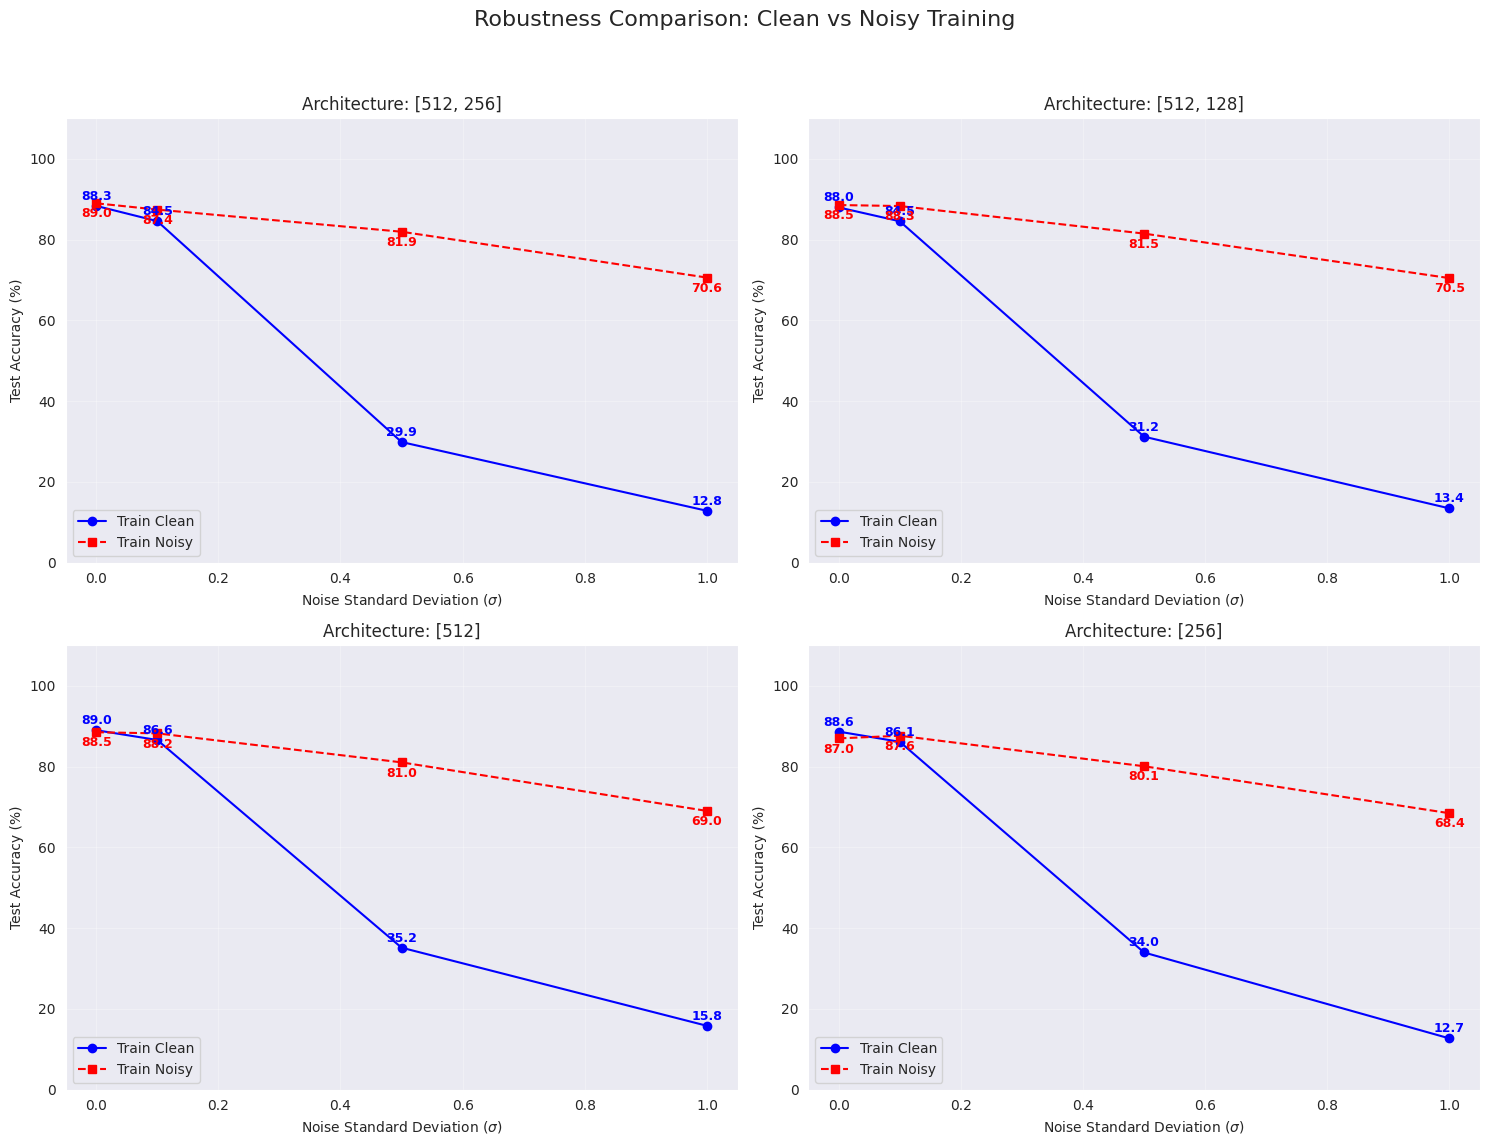

In [55]:
def plot_experiments(results, noise_levels):
    # Create 4 subplots (one for each architecture)
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))
    axs = axs.flatten()
    
    for i, (arch_name, res) in enumerate(results.items()):
        ax = axs[i]
        
        # Plot Scenario A (Blue)
        ax.plot(noise_levels, res['clean_train'], marker='o', linestyle='-', color='blue', label='Train Clean')
        
        # Plot Scenario B (Red)
        ax.plot(noise_levels, res['noisy_train'], marker='s', linestyle='--', color='red', label='Train Noisy')
        
        # Add labels
        for j, txt in enumerate(res['clean_train']):
            ax.text(noise_levels[j], txt + 1.5, f"{txt:.1f}", ha='center', color='blue', fontsize=9, fontweight='bold')
            
        for j, txt in enumerate(res['noisy_train']):
            ax.text(noise_levels[j], txt - 3.5, f"{txt:.1f}", ha='center', color='red', fontsize=9, fontweight='bold')

        ax.set_title(f"Architecture: {arch_name}")
        
        # --- POPRAWKA PONIŻEJ (dodano 'r' przed stringiem) ---
        ax.set_xlabel(r"Noise Standard Deviation ($\sigma$)") 
        
        ax.set_ylabel("Test Accuracy (%)")
        ax.set_ylim(0, 110)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='lower left')

    plt.suptitle("Robustness Comparison: Clean vs Noisy Training", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
plot_experiments(all_results, noise_levels)

From the results of the noise injection experiments, we can draw several conclusions:
- Training on clean data (Scenario A) leads to a significant drop in accuracy as noise levels increase during testing. This indicates that models trained only on clean data struggle to generalize to noisy inputs.
- Conversely, training on noisy data (Scenario B) helps the model become more robust to noise, maintaining higher accuracy even as noise levels increase.
- The gap between the two scenarios widens with higher noise levels, highlighting the importance of including noise during training for applications where input data may be corrupted
- Adding noise, made more complex architectures (like [512, 256]) perform better under noisy conditions, suggesting that higher capacity models can better learn to generalize in the presence of noise.